In [ ]:
# Make the Grid World, q-table and parameters
import numpy as np
row,col = 10,10
iteration_n = 5000
run_iteration = 50
startState = (2, 0)
goal = (0, col - 1)
actions = ['up','down','left','right']
discount = 0.9
alpha = 0.1
epsilon = 0.2
wall = [(1,1),(2,1),(3,1),(5,3), (0,3), (3,4)]
q_table = np.zeros((row, col, len(actions)))

In [ ]:
# Define action states
def is_valid_state(state):
    r, c = state
    if not (0 <= r < row and 0 <= c < col):
        return False
    if (r, c) in wall:
        return False
    return True
def takeAction(state, action_index):
    r, c = state
    action = actions[action_index]

    if action == 'up':
        next_state = (r - 1, c)
    elif action == 'down':
        next_state = (r + 1, c)
    elif action == 'left':
        next_state = (r, c - 1)
    elif action == 'right':
        next_state = (r, c + 1)
    else:
        next_state = state
    if not is_valid_state(next_state):
        return state
    return next_state
def choose_action(state, q_table, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        action_index = np.random.randint(len(actions))
    else:
        action_index = np.argmax(q_table[state[0], state[1]])
    return action_index

In [ ]:
# Train Q-learning
def q_learning_train(q_table, startState, goal, actions, row, col, iteration_n, discount, alpha, epsilon, wall):
    steps_per_episode = []
    for episode in range(iteration_n):
        current_state = startState
        done = False
        steps = 0
        while not done:
            steps += 1
            action_index = choose_action(current_state, q_table, epsilon)
            next_state = takeAction(current_state, action_index)
            reward = -1
            if next_state == goal:
                reward = 100
                done = True
            elif (next_state[0], next_state[1]) in wall:
                reward = -100
            old_q_value = q_table[current_state[0], current_state[1], action_index]
            max_future_q = np.max(q_table[next_state[0], next_state[1]])
            new_q_value = old_q_value + alpha * (reward + discount * max_future_q - old_q_value)
            q_table[current_state[0], current_state[1], action_index] = new_q_value
            current_state = next_state
            if steps > row * col * 2:
                break
        steps_per_episode.append(steps)
    return q_table, steps_per_episode
q_table_ql = np.zeros((row, col, len(actions)))
q_table_ql, ql_steps_per_episode = q_learning_train(
    q_table_ql, startState, goal, actions, row, col,
    iteration_n, discount, alpha, epsilon, wall
)


In [ ]:
# Train SASRA
def sarsa_train(q_table, startState, goal, actions, row, col, iteration_n, discount, alpha, epsilon, wall):
    steps_per_episode = []
    for episode in range(iteration_n):
        current_state = startState
        done = False
        steps = 0
        action_index = choose_action(current_state, q_table, epsilon)
        while not done:
            steps += 1
            next_state = takeAction(current_state, action_index)
            reward = -1
            if next_state == goal:
                reward = 100
                done = True
            elif (next_state[0], next_state[1]) in wall:
                reward = -100
            next_action_index = choose_action(next_state, q_table, epsilon)
            old_q_value = q_table[current_state[0], current_state[1], action_index]
            future_q_value = q_table[next_state[0], next_state[1], next_action_index]
            new_q_value = old_q_value + alpha * (reward + discount * future_q_value - old_q_value)
            q_table[current_state[0], current_state[1], action_index] = new_q_value
            current_state = next_state
            action_index = next_action_index
            if steps > row * col * 2:
                break
        steps_per_episode.append(steps)
    return q_table, steps_per_episode
q_table_sarsa = np.zeros((row, col, len(actions)))
q_table_sarsa, sarsa_steps_per_episode = sarsa_train(
    q_table_sarsa, startState, goal, actions, row, col,
    iteration_n, discount, alpha, epsilon, wall
)


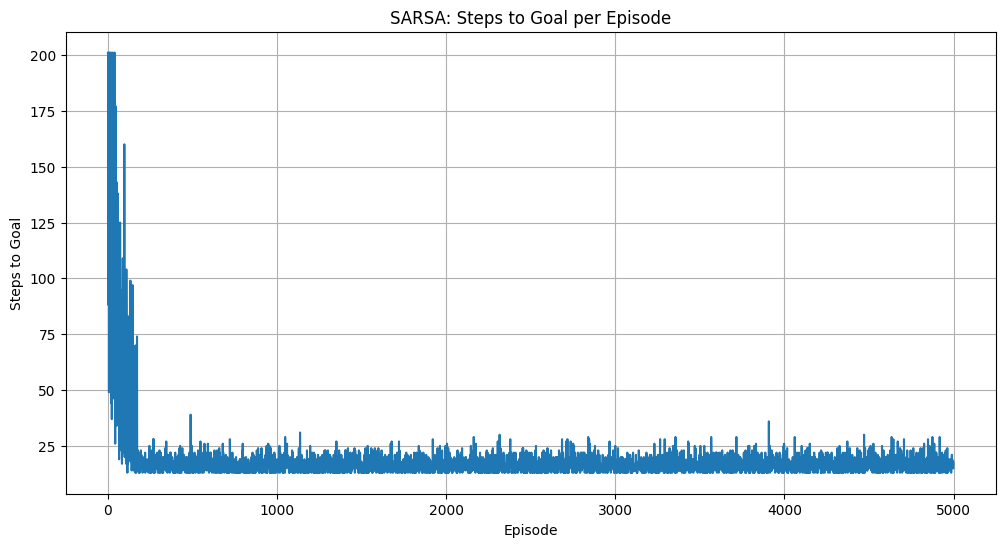

In [ ]:
# Plot SASRA
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(sarsa_steps_per_episode)
plt.xlabel('Episode')
plt.ylabel('Steps to Goal')
plt.title('SARSA: Steps to Goal per Episode')
plt.grid(True)
plt.show()


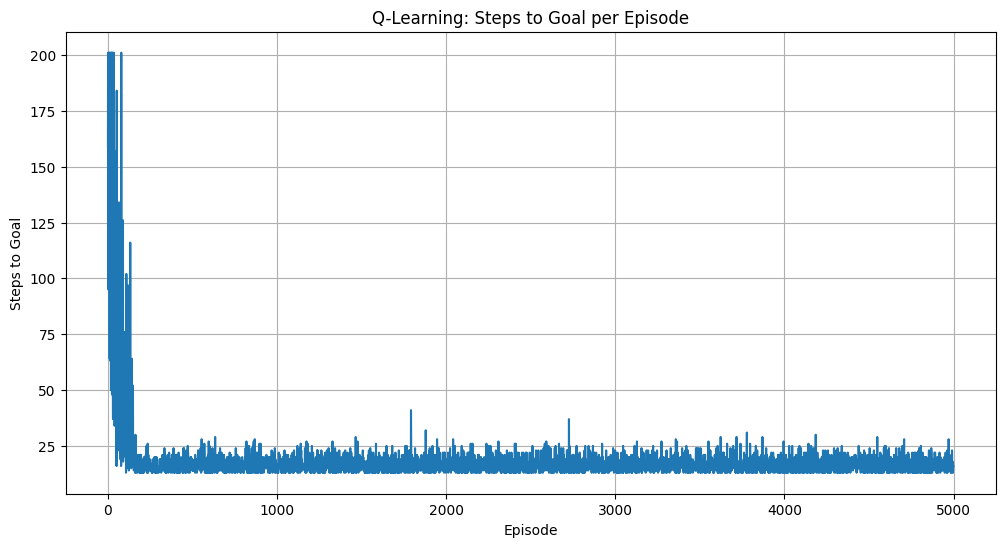

In [ ]:
# Plot Q-learning
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(ql_steps_per_episode)
plt.xlabel('Episode')
plt.ylabel('Steps to Goal')
plt.title('Q-Learning: Steps to Goal per Episode')
plt.grid(True)
plt.show()


In [ ]:
# Create theoretical value table
def get_reward_vi(next_state, goal_state):
    if next_state == goal_state:
        return 100
    return -1
def value_iteration(row, col, actions, goal, wall, discount, epsilon=1e-6, max_iterations=1000):
    V = np.zeros((row, col))
    for _ in range(max_iterations):
        delta = 0
        new_V = np.copy(V)

        for r in range(row):
            for c in range(col):
                state = (r, c)
                if state == goal:
                    new_V[r, c] = 0
                    continue
                if not is_valid_state(state):
                    new_V[r, c] = -1e9
                    continue
                q_values_for_state = []
                for action_index in range(len(actions)):
                    possible_next_state = takeAction(state, action_index)
                    reward = get_reward_vi(possible_next_state, goal)
                    q_values_for_state.append(reward + discount * V[possible_next_state[0], possible_next_state[1]])
                if q_values_for_state:
                    new_V[r, c] = np.max(q_values_for_state)
                else:
                    new_V[r, c] = V[r, c]
        delta = np.max(np.abs(new_V - V))
        V = new_V

        if delta < epsilon:
            break
    return V
theoretical_value_table = value_iteration(row, col, actions, goal, wall, discount)
formatted_table = np.full((row, col), '      ', dtype='<U6')
for r in range(row):
    for c in range(col):
        if (r,c) == goal:
            formatted_table[r,c] = 'GOAL'
        elif (r,c) in wall:
            formatted_table[r,c] = 'WALL'
        else:
            val = theoretical_value_table[r,c]
            if val < -1e8:
                 formatted_table[r,c] = 'WALL'
            else:
                formatted_table[r,c] = f'{val:.2f}'
for r in range(row):
    row_str = " ".join(f"{item:>6}" for item in formatted_table[r])
    print(row_str)

 28.35  32.62  37.35   WALL  62.17  70.19  79.10  89.00 100.00   GOAL
 24.52   WALL  42.61  48.46  54.95  62.17  70.19  79.10  89.00 100.00
 21.07   WALL  37.35  42.61  48.46  54.95  62.17  70.19  79.10  89.00
 17.96   WALL  32.62  37.35   WALL  48.46  54.95  62.17  70.19  79.10
 21.07  24.52  28.35  32.62  37.35  42.61  48.46  54.95  62.17  70.19
 17.96  21.07  24.52   WALL  32.62  37.35  42.61  48.46  54.95  62.17
 15.16  17.96  21.07  24.52  28.35  32.62  37.35  42.61  48.46  54.95
 12.65  15.16  17.96  21.07  24.52  28.35  32.62  37.35  42.61  48.46
 10.38  12.65  15.16  17.96  21.07  24.52  28.35  32.62  37.35  42.61
  8.34  10.38  12.65  15.16  17.96  21.07  24.52  28.35  32.62  37.35


In [ ]:
# Calculate sum of sqaured error
def calculate_sse(learned_q_table, theoretical_value_table, row, col, wall):
    sse = 0.0
    num_states = 0
    for r in range(row):
        for c in range(col):
            state = (r, c)
            if state in wall or state == goal:
                continue
            if theoretical_value_table[r, c] < -1e8:
                continue
            learned_value = np.max(learned_q_table[r, c])
            theoretical_value = theoretical_value_table[r, c]
            sse += (learned_value - theoretical_value) ** 2
            num_states += 1
    return sse, num_states
sse_ql, num_states_ql = calculate_sse(q_table_ql, theoretical_value_table, row, col, wall)
print(f"Q-Learning Sum of Squared Error: {sse_ql:.4f}")
sse_sarsa, num_states_sarsa = calculate_sse(q_table_sarsa, theoretical_value_table, row, col, wall)
print(f"SARSA Sum of Squared Error: {sse_sarsa:.4f}")

Q-Learning Sum of Squared Error: 76193.0417
SARSA Sum of Squared Error: 74732.6435
